## Import Libraries

In [7]:
import cv2 as cv
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from pickle import load, dump
from os import listdir, path
from IPython.display import display, Image, Video
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dropout, add, LSTM, Dense, Embedding
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from nltk.translate.bleu_score import corpus_bleu

## VGG16 Model and Image Feature Extraction

In [8]:
img_model = VGG16()  # defining the pre-trained VGG16 model
img_model = Model(inputs=img_model.inputs, outputs=img_model.layers[-2].output)

In [9]:
img_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
img_features = {}
images_dir = '../dataset/images/'

for file_name in tqdm(listdir(images_dir)):
    filepath = images_dir + '/' + file_name
    img = load_img(filepath, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    img_feature = model.predict(img, verbose=0)
    img_id = file_name.split('.')[0]
    img_features[img_id] = img_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
# with open('../dataset/features.pkl', 'wb') as file:
#     pickle.dump(img_features, file)

In [11]:
# load features from pickle
with open('../dataset/' + 'features.pkl', 'rb') as f:
    img_features = load(f)

In [12]:
len(img_features)

8091

## Load the Captions Data

In [13]:
with open('../dataset/captions.txt', 'r') as file:
    next(file)
    cap_text = file.read()

In [14]:
img_cap_mapping = {}

for text in tqdm(cap_text.split('\n')):
    wordlist = text.split(',')
    if len(text) < 2:
        continue
    img_id, cap = wordlist[0], wordlist[1:]
    id = img_id.split('.')[0]

    cap = " ".join(cap)

    if id not in img_cap_mapping:
        img_cap_mapping[id] = []
    
    img_cap_mapping[id].append(cap)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [15]:
len(img_cap_mapping)

8091

## Text Caption - Data Preprocessing

In [16]:
def clean_captions(img_cap_mapping):
    for k, v in img_cap_mapping.items():
        for i in range(len(v)):
            cap_text = v[i]
            cap_text = cap_text.lower()
            cap_text = cap_text.replace('[^A-Za-z]', '')
            cap_text = cap_text.replace('\s+', ' ')
            cap_text = 'startseq ' + " ".join([word for word in cap_text.split() if len(word)>1]) + ' endseq'
            v[i] = cap_text

In [17]:
img_cap_mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [18]:
clean_captions(img_cap_mapping)

In [19]:
img_cap_mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [20]:
caplist = []
for k in img_cap_mapping:
    for cap_text in img_cap_mapping[k]:
        caplist.append(cap_text)

In [21]:
len(caplist)

40455

In [22]:
caplist[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(caplist)

In [24]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [25]:
max_length = max([len(cap.split()) for cap in caplist])
max_length

35

In [43]:
with open("../dataset/tokenizers.pkl", "wb") as file:
    dump(tokenizer, file)

## Splitting into Training and Testing Data

In [26]:
img_ids = list(img_cap_mapping.keys())
ratio = int(len(img_ids) * 0.90)
train_data = img_ids[:ratio]
test_data = img_ids[ratio:]

In [27]:
def custom_data_generator(keys_list, mapping_dict, features_dict, custom_tokenizer, max_sequence_length, vocab_size, batch_size_custom):
    x_custom1, x_custom2, y_custom = list(), list(), list()
    n_custom = 0
    while 1:
        for custom_key in keys_list:
            n_custom += 1
            custom_captions = mapping_dict[custom_key]
            for custom_caption in custom_captions:
                custom_seq = custom_tokenizer.texts_to_sequences([custom_caption])[0]
                for i_custom in range(1, len(custom_seq)):
                    in_custom_seq, out_custom_seq = custom_seq[:i_custom], custom_seq[i_custom]
                    in_custom_seq = pad_sequences([in_custom_seq], maxlen=max_sequence_length)[0]
                    out_custom_seq = to_categorical([out_custom_seq], num_classes=vocab_size)[0]
                    x_custom1.append(features_dict[custom_key + '.jpg'][0])
                    x_custom2.append(in_custom_seq)
                    y_custom.append(out_custom_seq)
            if n_custom == batch_size_custom:
                x_custom1, x_custom2, y_custom = np.array(x_custom1), np.array(x_custom2), np.array(y_custom)
                yield [x_custom1, x_custom2], y_custom
                x_custom1, x_custom2, y_custom = list(), list(), list()
                n_custom = 0


## Model Development and Training

In [66]:

input_img_features = Input(shape=(4096,))
img_dropout = Dropout(0.4)(input_img_features)
img_dense = Dense(256, activation='relu')(img_dropout)


input_sequence = Input(shape=(max_length,))
seq_embedding = Embedding(vocab_size, 256, mask_zero=True)(input_sequence)
seq_dropout = Dropout(0.4)(seq_embedding)
seq_lstm = LSTM(256)(seq_dropout)


decoder_add = add([img_dense, seq_lstm])
decoder_dense = Dense(256, activation='relu')(decoder_add)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense)

caption_model = Model(inputs=[input_img_features, input_sequence], outputs=output_layer)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(caption_model, show_shapes=True)
caption_model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              2172160   ['input_6[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 4096) 

In [69]:
epochs = 25
batch_size = 32
per_epoch_step = len(train_data) // batch_size

for epoch in range(epochs):
    batch_generator = custom_data_generator(train_data, img_cap_mapping, img_features, tokenizer, max_length, vocab_size, batch_size)
    caption_model.fit(batch_generator, epochs=1, steps_per_epoch=per_epoch_step, verbose=1)

227/227 [==============================] - 1035s 5s/step - loss: 2.3850


In [71]:
caption_model.save('../dataset/caption_model.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../dataset/caption_model\assets


INFO:tensorflow:Assets written to: ../dataset/caption_model\assets


## Model Testing

In [28]:
caption_model = load_model('../dataset/' + 'caption_model.h5')

In [29]:
def index_to_word_conversion(index_val, custom_tokenizer):
    for word_val, idx_val in custom_tokenizer.word_index.items():
        if idx_val == index_val:
            return word_val
    return None

In [30]:
def generate_caption(custom_model, input_image, custom_tokenizer, max_seq_length):
    input_text = 'startseq'
    for _ in range(max_seq_length):
        input_seq = custom_tokenizer.texts_to_sequences([input_text])[0]
        input_seq = pad_sequences([input_seq], max_seq_length)
        prediction = caption_model.predict([input_image, input_seq], verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_word = index_to_word_conversion(predicted_index, custom_tokenizer)
        if predicted_word is None:
            break
        input_text += " " + predicted_word
        if predicted_word == 'endseq':
            break

    return input_text

In [44]:
actual_captions, predicted_captions = list(), list()

for key_val in tqdm(test_data):
    captions_list = img_cap_mapping[key_val]
    predicted_caption = generate_caption(caption_model, img_features[key_val + '.jpg'], tokenizer, max_length)
    actual_captions_list = [caption.split() for caption in captions_list]
    predicted_caption_words = predicted_caption.split()
    actual_captions.append(actual_captions_list)
    predicted_captions.append(predicted_caption_words)

print("BLEU-1: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.482162
BLEU-2: 0.246844


## Visualization of Generated Captions

In [45]:
def generate_and_display_captions(image_filename):
    image_id = image_filename.split('.')[0]
    image_path = path.join("../dataset/images/", image_filename)
    image = Image.open(image_path)
    actual_captions = img_cap_mapping[image_id]
    
    # Predict the caption
    predicted_caption = generate_caption(caption_model, img_features[image_filename], tokenizer, max_length)
    
    # Display actual and predicted captions side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Display actual captions below the image
    axes[0].imshow(image)
    axes[0].set_title('Actual Captions')
    axes[0].axis('off')
    actual_caption_str = '\n'.join(actual_captions)
    axes[0].text(0, -0.35, actual_caption_str, fontsize=10, verticalalignment='bottom', color='green', transform=axes[0].transAxes)

    # Display predicted caption below the image
    axes[1].imshow(image)
    axes[1].set_title('Predicted Caption')
    axes[1].axis('off')
    axes[1].text(0, -0.09, predicted_caption, fontsize=10, verticalalignment='bottom', color='red', transform=axes[1].transAxes)

    plt.show()

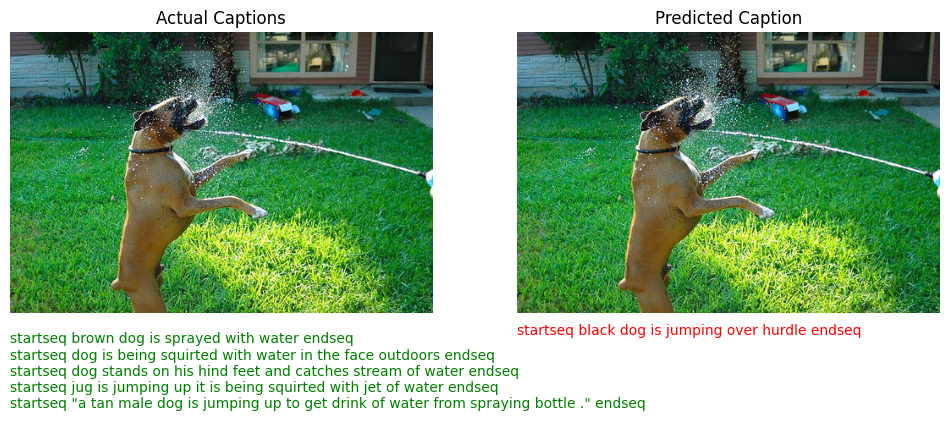

In [46]:
generate_and_display_captions("44856031_0d82c2c7d1.jpg")

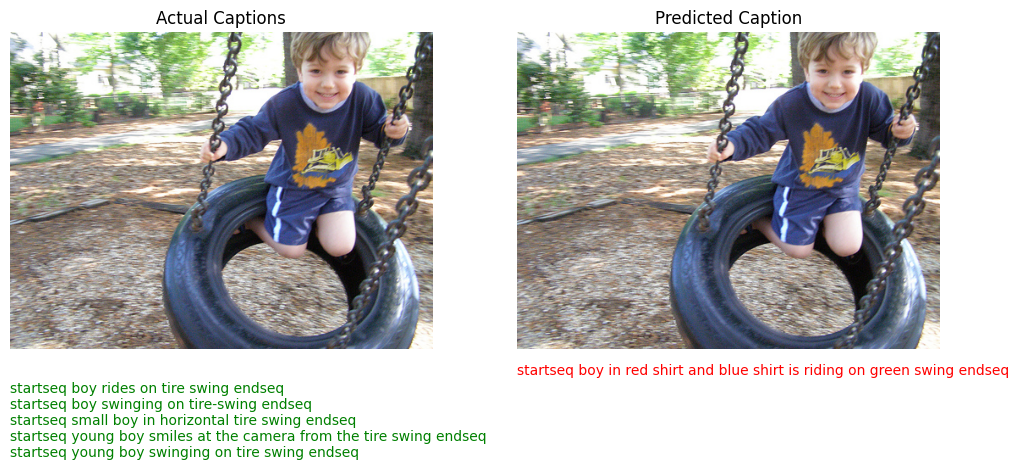

In [47]:
generate_and_display_captions("136644343_0e2b423829.jpg")

## Real Image Testing

In [50]:
def predict_caption_test(img_path):
    sample_img = load_img(img_path, target_size=(224, 224))

    sample_img = img_to_array(sample_img)
    sample_img = sample_img.reshape((1, sample_img.shape[0], sample_img.shape[1], sample_img.shape[2]))
    sample_img = preprocess_input(sample_img)

    img_feature = img_model.predict(sample_img, verbose=0)

    # Display the sample image
    plt.imshow(load_img(img_path, target_size=(224, 224)))
    plt.title('Sample Image')
    plt.axis('off')
    plt.show()

    # Generate and display the caption with custom font and color
    generated_caption = generate_caption(caption_model, img_feature, tokenizer, max_length)

    # Display the predicted caption with custom font and color
    print("Predicted Caption:")
    plt.figure(figsize=(1, 0.1))
    plt.text(0, 0, generated_caption, fontsize=12, color='red', fontdict={'family': 'serif', 'weight': 'normal'})
    plt.axis('off')
    plt.show()

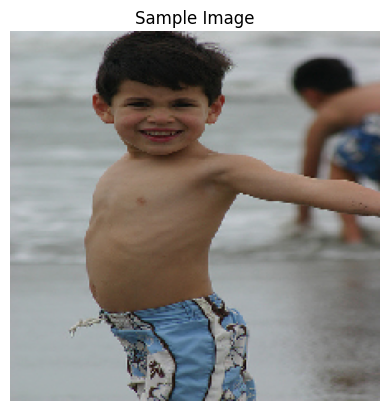

Predicted Caption:


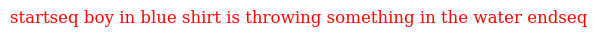

In [52]:
img_path = '../dataset/sample_img/sample4.jpg'
predict_caption_test(img_path)

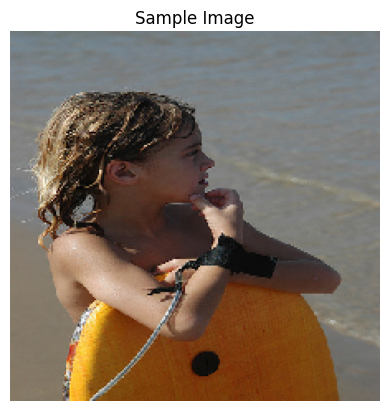

Predicted Caption:


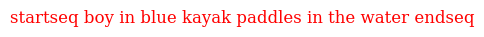

In [62]:
test_img_id = test_data[np.random.randint(0, len(test_data))]
predict_caption_test(f'../dataset/images/{test_img_id}.jpg')

# Video Testing

In [4]:
video_path = r'../dataset/sample_img/sample2.mp4'

In [5]:
Video(video_path, embed=True, width=400, height=300)

In [62]:
import PIL

def video_captioning(video_path=None, n_frames=10):   
    if video_path:
        video_capture = cv.VideoCapture(video_path) 
    else:
        video_capture = cv.VideoCapture(0)

    if not video_capture.isOpened():
        print("Error: Could not open video source.")
        exit()

    frame_counter = 0
    while True:
        # Read a frame from the video source
        ret, frame = video_capture.read()

        # If the frame is not successfully read, break the loop
        if not ret:
            break
        
        if frame_counter < n_frames:
            frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            
            if not video_path:
                # Display the frame
                display(PIL.Image.fromarray(frame_rgb))
                
            # Resize the frame to (224, 224)
            resized_frame = cv.resize(frame_rgb, (224, 224))

            # Add an extra dimension to match the expected input shape
            img = np.expand_dims(resized_frame, axis=0)

            # Preprocess the image
            img = preprocess_input(img)

            # Predict using the model
            img_feature = img_model.predict(img, verbose=0)
            caption = generate_caption(caption_model, img_feature, tokenizer, max_length)
            
            frame_counter += 1
            
            print(f"Predicted Caption: \033[1m Frame {frame_counter}\033[0m")
            plt.figure(figsize=(1, 0.1))
            plt.text(0, 0, caption, fontsize=12, color='red', fontdict={'family': 'serif', 'weight': 'normal'})
            plt.axis('off')
            plt.show()
            
        else:
            break

    # Release the video capture object and close all windows
    video_capture.release()
    cv.destroyAllWindows()

Predicted Caption:  Frame 1


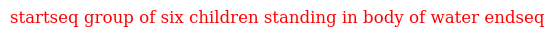

Predicted Caption:  Frame 2


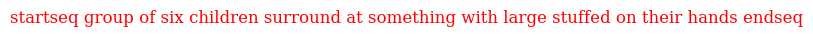

Predicted Caption:  Frame 3


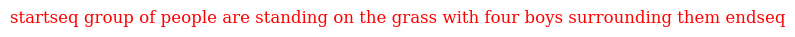

Predicted Caption:  Frame 4


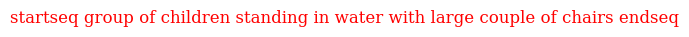

Predicted Caption:  Frame 5


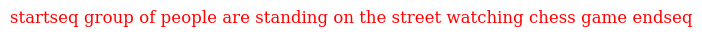

In [63]:
video_captioning(video_path, n_frames=5)

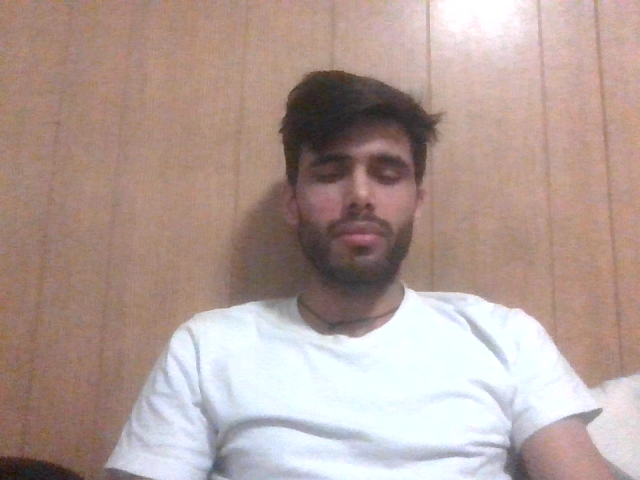

Predicted Caption:  Frame 1


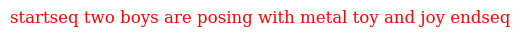

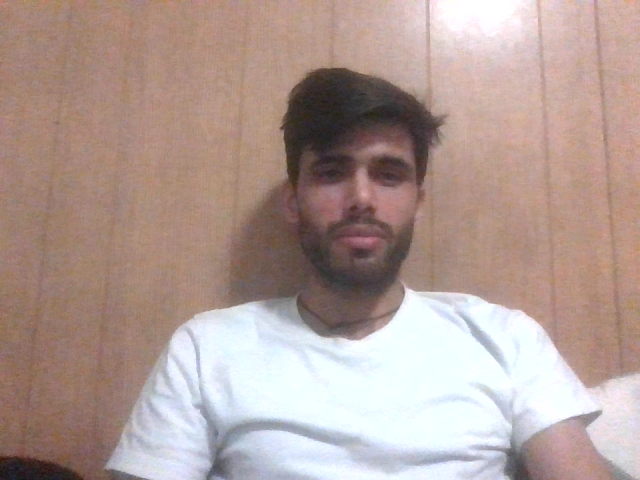

Predicted Caption:  Frame 2


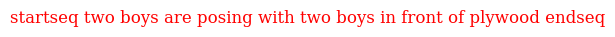

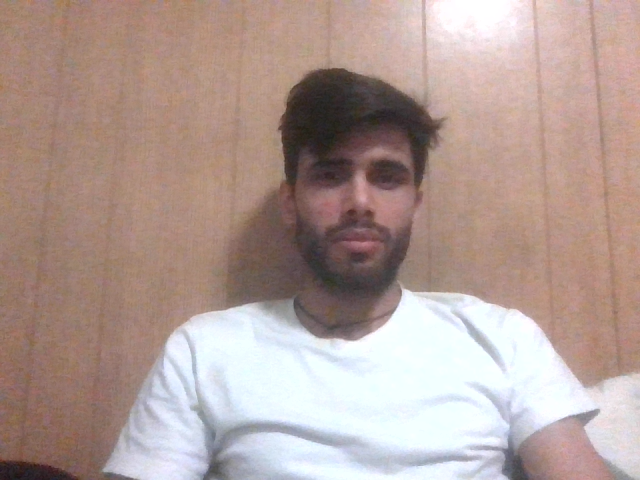

Predicted Caption:  Frame 3


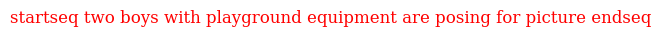

In [68]:
video_captioning(n_frames=3)